<a href="https://colab.research.google.com/github/mschilling314/Perceptron/blob/main/perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1: The Perceptron

In this notebook, we'll explore the __perceptron__ model in the context of a binary classification task. We'll build a simple percepton model with NumPy and observe how it performs on a number of synthetic datasets.

The notebook is broken up as follows:

  1. <a href="#setup">Setup</a>
  2. [Simple Perceptron](#perceptron)
  3. [Training and Testing on Data](#train)

## __1.__ <a name="setup">Setup</a>

We'll start by importing utility functions to create and plot simple two-dimensional datasets.

**NOTE** This may require you have to create and set up a personal access token to work with GitHub. Click [here](https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d) to learn how.

In [ ]:
# helper code from the course repository
!cd /content && git clone https://github.com/zachwooddoughty/cs449w23.git
# install common pacakges used for deep learning
!cd cs449w23/ && pip install -q -r requirements.txt

Cloning into 'cs449w23'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 58 (delta 10), reused 49 (delta 6), pack-reused 0
Unpacking objects: 100% (58/58), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.5 MB/s eta 0:00:00


In [ ]:
# this "magic" command makes graphics produced by matplotlib appear in the notebook.
%matplotlib inline

# make sure we're in the right directory
%cd /content/cs449w23/

import torch                  # This is PyTorch, what we're using for deep learning in class 
import numpy as np            # standard numerical processing library
from utils.plotting import *  # see plotting.py for plotting utilities
from utils.data import *      # see data.py for dataset utilities  
print("Hiya")

/content/cs449w23
Hiya


In a __binary classification__ task, our goal is to build a model capable of separating the positive and negative classes. Given an input, our model will predict a label (-1 or +1) corresponding to one of the classes.

## __2.__ <a name="perceptron">Simple Perceptron</a>

We can train a linear (single-layer) perceptron to perform binary classification. A linear perceptron "draws" a hyperplane in the input space that separates the positive and negative classes, with points lying on each side of the hyperplane assigned to opposite classes.

<br/>
<center>
<img width="400px" src="https://raw.githubusercontent.com/zachwooddoughty/cs449w23/main/notebooks/static/boundary.png"/>
</center>
<br/>

How does the perceptron "learn" to draw a separating hyperplane? Like many other binary classification approaches (e.g. logistic regression), we can adjust a set of __weights__ that describe a linear boundary in the $d$-dimensional input space. For weights $\mathbf{w} = \{w_0, ..., w_d\}$ and arbitrary input $\mathbf{x} = \{x_0, ..., x_d\}$, we will define the perceptron's prediction as 

$$
\begin{cases}
      +1 & \text{if}\ \mathbf{w}^T \mathbf{x} \geq 0 \\
      -1 & \text{if}\ \mathbf{w}^T \mathbf{x} < 0 \\
 \end{cases}  
$$

As shown in the figure above, it is common to include a __bias__ term; we can do so by simply extending the input dimension such that $\mathbf{x} = \{1, x_0, ..., x_d\}$ and $\mathbf{w} = \{b, w_0, ..., w_d\}$, meaning the extra weight is interpreted as a bias. Iterating over our dataset, we will tweak these weights based on our model's predictions until the model __converges__ or we reach an iteration limit.

We can describe this process in pseudocode:

  <pre>
  <b>begin</b> initialize weights
     <b>while</b> not converged or not exceeded maxEpochs
          <b>for</b> each example in features
              <b>if</b> example is misclassified using weights
              <b>then</b> weights = weights + example * label_for_example * step_size
     <b>return</b> weights
  <b>end</b>
  </pre>


In [ ]:
class Perceptron:
    
    def __init__(self):
        
        self.weights = None

    def fit_single_epoch(self, data, labels, weights, step_size=1, verbose = False):
        """ 
        Train a linear perceptron by iterating exactly once over the data.

        PARAMETERS
        ----------

        data       A numpy array of real values with n rows and d columns, where n
                   is the number of data points and d is the number of dimensions.

        labels     A vector containing labels drawn from {1,-1}. The jth label
                   is the label of the jth example data point in data.

        weights    A vector of d+1 weights for a 1950's style perceptron, where d is 
                   the number of dimensions of the data

        step_size  A positive real value in the range 0 < step_size <= 1

        verbose    If true, it will print out its calculations after every
                   looking at each data point

        RETURNS
        -------
        converged  Set to 1 if a line that separated the two classes was found. 
                   Else it is set to 0.

        weights    A vector of d+1 weights that characterize the hyperplane that
                   separates the data (if it convereged). If data has 3 dimensions, 
                   then weights will have 4 elements. The first element is the 
                   bias (aka offset), the remaining weights correspond to the weight
                   associated with each of the 3 dimensions of the data.
        """

        # To do the perceptron algorithm, add a column of ones to the data, these
        # will correspond to the bias.
        num_points,num_dimensions = np.shape(data)
        b = np.ones(num_points)
        bias = np.expand_dims(b,axis=1)
        data_plus = np.append(bias,data,axis=1)

        converged = 1; # we're being optimistic.

        # iterate over every element in the data
        for n in range(0,num_points):
          point = data_plus[n]
          label = labels[n]

          # this is where the perceptron classifies
          estimated_label = np.sign(np.sum(np.multiply(weights,point)))

          if verbose:
            print(' point = ', point, '  label = ', label, ' estimated_label = ', estimated_label)
            print('old weights = ', np.round(weights, 3))

          # This is where the perceptron updates
          if (estimated_label != label):
            converged=0  # admit we haven't converged 
            weights = weights + (step_size * label * point) #change the weights of the hyperplane
            if verbose: print('new weights = ', np.round(weights, 3))

        return converged, weights  

    def fit(self, 
            data: np.ndarray, 
            labels: np.ndarray, 
            step_size: float = 1.0, 
            max_iter: int = 10,
            verbose: bool = False):
        """ 
        Train a linear perceptron by iterating over the data until an iteration
        limit is reached or the model converges.

        PARAMETERS
        ----------

        data       A numpy array of real values with n rows and d columns, where n
                   is the number of data points and d is the number of dimensions.

        labels     A vector containing labels drawn from {1,-1}. The jth label
                   is the label of the jth example data point in data.

        step_size  A positive real value in the range 0 < step_size <= 1
        
        max_iter   The maximum number of iterations to perform

        verbose    If true, it will print out its calculations after every
                   looking at each data point
        """
        
        # set the weights of the perceptron to an inital set of random values, 
        # and make sure to include "extra" bias weight
        if self.weights is None:
            n_features = data.shape[-1]
            weights = np.random.rand(1, n_features + 1)
        else:
            weights = self.weights
        
        for num_iter in range(max_iter):
            
            converged, weights = self.fit_single_epoch(data, labels, weights, 1/(num_iter+1), verbose)
            
            if converged:
                break
                
        # store learned weights
        self.weights = weights
    
    def predict(self, data: np.ndarray):
        """ 
        This predicts a label (+1 or -1) for each example in the data and returns 
        predictions as a numpy array.

        PARAMETERS
        ----------

        data     A numpy array of real values with n rows and d columns, where n
                 is the number of data points and d is the number of dimensions.
                 Each row is a data point to be classiified.

        RETURNS
        -------
        A vector with n labels drawn from (+1 or -1), where the ith
        label is the predicted label of the ith data point 
        """
        
        # To do the perceptron algorithm, add a column of ones to the data, these
        # will correspond to the bias.
        num_points,num_dimensions = np.shape(data)
        b = np.ones(num_points)
        bias = np.expand_dims(b,axis=1)
        data_plus = np.append(bias,data,axis=1)

        # now predict classes
        class_prediction = np.zeros(num_points)
        for n in range(0,num_points):
            point = data_plus[n]
            class_prediction[n] = np.sign(np.sum(np.multiply(self.weights, point)))
            if class_prediction[n] == 0:
              class_prediction[n] = 1

        return class_prediction


    def __call__(self, data: np.ndarray):
        return self.predict(data)
        

## __3.__ <a name="train">Training and Testing on Data</a>

Below, we'll try out four synthetic datasets:

  * `make_two_gaussians_data` draws data points from a mixture of two Gaussians
  * `make_center_surround_data` places data in two concentric circles
  * `make_XOR_data` generates data representing the XOR boolean function
  * `make_spiral_data` arranges the data in two spirals
  
In all cases, our data has two possible labels (-1 and +1) representing two classes. Let's have a look at an easy dataset to just see what it looks like.

[ 1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1. -1. -1. -1.  1. -1. -1.  1.
 -1. -1.  1. -1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1.  1. -1.  1.
 -1. -1. -1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.  1. -1.  1.
  1.  1.  1.  1. -1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1.
 -1. -1.  1. -1. -1.  1.  1.  1. -1. -1. -1. -1.  1. -1. -1.  1.  1.  1.
 -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.]


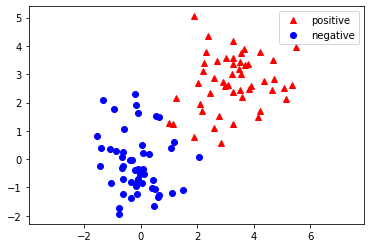

In [ ]:
data, labels = make_two_gaussians_data(50,distance_between_means=3)
plot_data(data, labels)

print(labels)

We can now look at how our perceptron model performs when we train it on the various datasets. To show how the learning algorithm works in practice, we will visualize the model's learned decision boundary over a small number of training iterations. Note that the perceptron training algorithm _will only update weights when an incorrect prediction is made_. Therefore, the boundary may remain fixed for many iterations at a time.

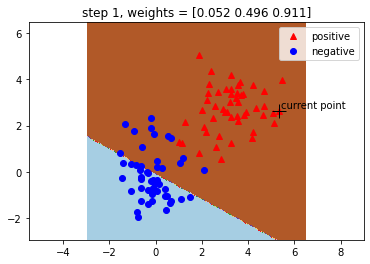

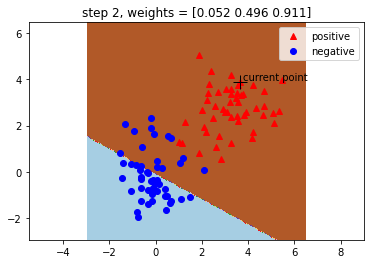

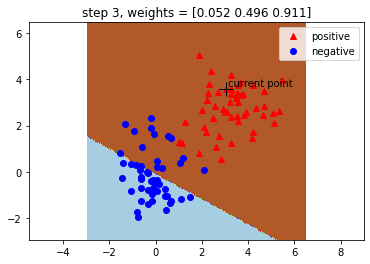

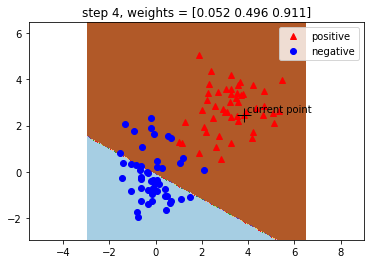

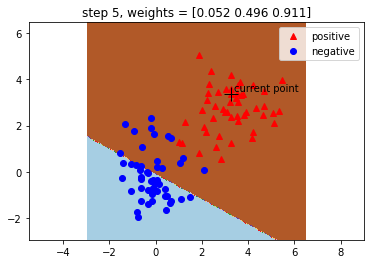

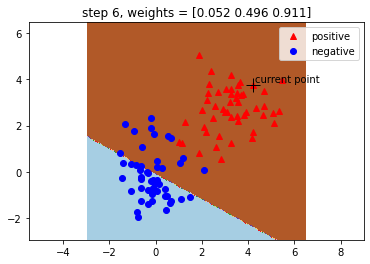

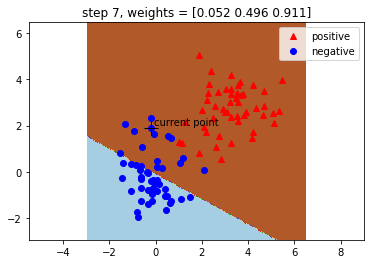

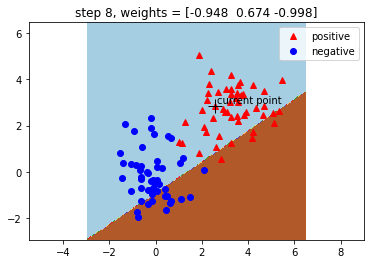

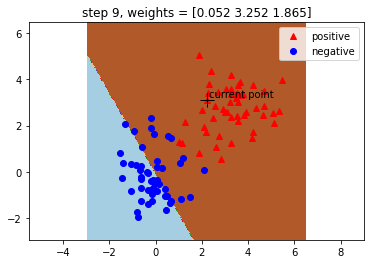

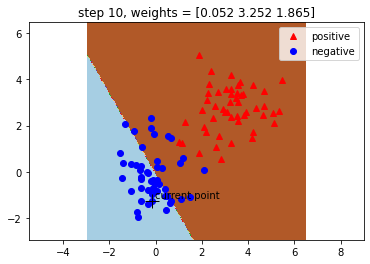

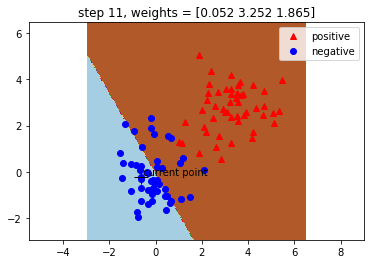

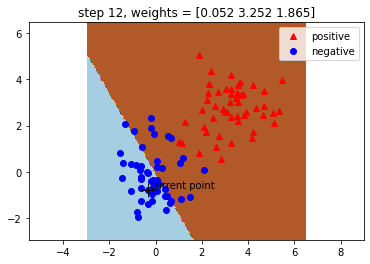

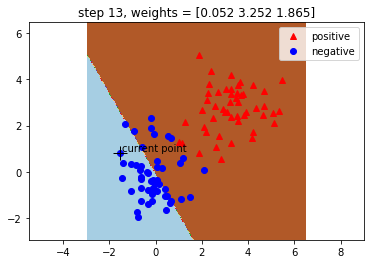

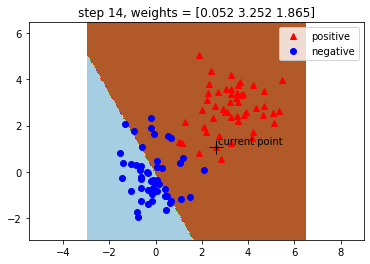

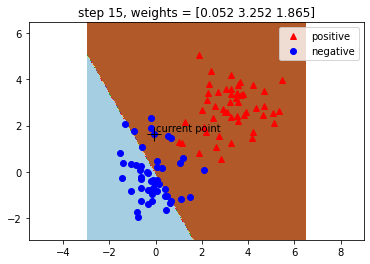

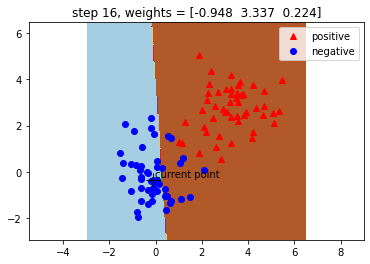

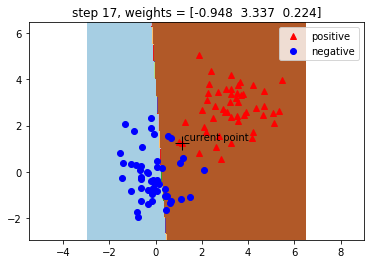

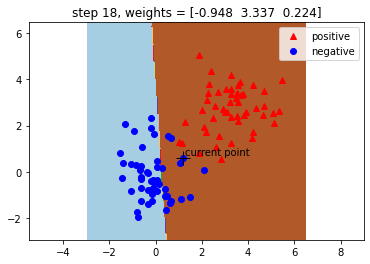

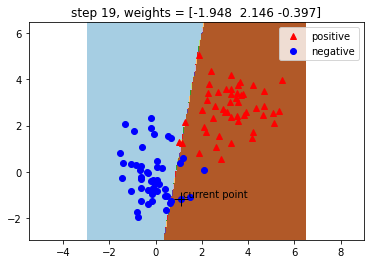

In [ ]:

# set the boundaries of decision plot
data_min = np.min(np.min(data))
data_max = np.max(np.max(data))
num_points, num_dimensions = np.shape(data)

# initialize model
perceptron = Perceptron()

# train the model and visualize decision boundary, one step at a time

for i in range(20):
    
    # select one data point
    data_single_point, label_single_point = data[i:i+1], labels[i:i+1]
    
    if i >= 1:
        fig, ax = plt.subplots()

        # plot the perceptron's current learned decision boundary
        plot_decision_surface(perceptron, axis_limits=[data_min-1, data_max+1, data_min-1, data_max+1], ax=ax)

        # visualize the data point
        dummy = plt.text(data_single_point[:, 0] + 0.1, data_single_point[:, 1] + 0.1, 'current point')
        plot_data(data, labels, ax)
        plt.gca().plot(data_single_point[:, 0], data_single_point[:, 1], 'k+', markersize=14)

        # look at the weights
        title =  "step " + str(i) + ", weights = " + str(np.squeeze(np.round(perceptron.weights, 3)))
        plt.title(title)
        plt.show()

    # fit the perceptron using the data point
    perceptron.fit(data_single_point, label_single_point, step_size=0.2, max_iter=1, verbose=False)

In the plots above, we can see how the perceptron iteratively adjusts its weights in response to incorrect predictions. Now that we have a sense of how the perceptron model learns, let's go ahead an do a complete training run on all of our datasets.

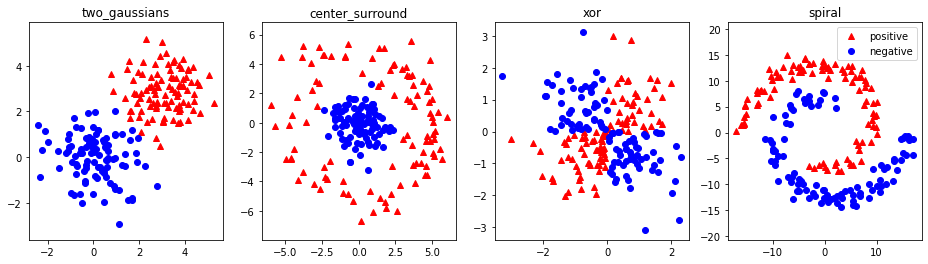

In [ ]:
# Datasets
datasets = {
  "two_gaussians": make_two_gaussians_data(examples_per_class=100, distance_between_means=3),
  "center_surround": make_center_surround_data(examples_per_class=100, distance_from_origin=5),
  "xor": make_XOR_data(examples_per_class=100),
  "spiral": make_spiral_data(examples_per_class=100),
}

fig, axes = plt.subplots(nrows=1, ncols=len(datasets), figsize=(16, 4))
for idx, name in enumerate(datasets):
   data, labels = datasets[name]
   plot_data(data, labels, axes[idx])
   axes[idx].set_title(name)

plt.show()


Uncomment the name of the dataset you'd like to train the perceptron on. Which of these datasets are  __linearly separable__ ? Is the perceptron capable of drawing anything other than a separating hyperplane in the input space?

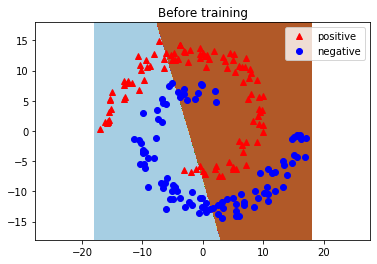

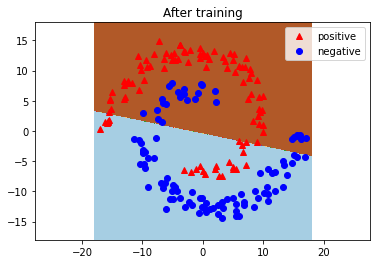

In [ ]:
#name = "two_gaussians"
#name = "center_surround"
#name = "xor"
name = "spiral"
data, labels = datasets[name]

# set the boundaries of decision plot
data_min = np.min(np.min(data))
data_max = np.max(np.max(data))
num_points, num_dimensions = np.shape(data)

# initialize model
perceptron = Perceptron() 

# plot the perceptron's iniial decision boundary
perceptron.fit(data, labels, step_size=0.2, max_iter=0, verbose=False)
fig, ax = plt.subplots()
plt.title("Before training")
plot_decision_surface(perceptron, axis_limits=[data_min-1, data_max+1, data_min-1, data_max+1], ax=ax)
plot_data(data, labels, ax)

# fit the perceptron using the entire dataset
perceptron.fit(data, labels, step_size=0.2, max_iter=1000, verbose=False)

# plot the perceptron's learned decision boundary
fig, ax = plt.subplots()
plt.title("After training")
plot_decision_surface(perceptron, axis_limits=[data_min-1, data_max+1, data_min-1, data_max+1], ax=ax)
plot_data(data, labels, ax)

plt.show()